In [57]:
import evolvepy as ep
import numpy as np
import matplotlib.pyplot as plt

# 3-CNF-SAT

In this exemple we are going to see an exemple of Conjunctive Normal Form Satisfability. In this exemple we will show the CNF with 3 literals clauses. ALthough the code can cover the problem for n-cnf-sat.

## setting the expression

First of all we are going to write a exemple expression. They are a combination of clauses joined by the boolean symbol "+" which stands for AND. Those clauses are combinations of literals joined by the boolean symbol "*" which stands for OR and each literal can be negated with the symbol "!" which stands for NOT.

In [58]:
# here we define the logical expression, it need to be contained in parenthesis and the variables.
expression = "(a*b*c)+(!a*a*c)"
# here we define the number of nonrepeating literals used in the expression.
n_variables = 3

#### dictionary for the variables

In [59]:
alphabet = {'a':0,'b':1,'c':2,'d':3,'e':4,'f':5,'g':6,'h':7,'i':8,'j':9,'k':10,'l':11,'m':12,'n':13,'o':14,
'p':15,'q':16,'r':17,'s':18,'t':19,'u':20,'v':21,'w':22,'x':23,'y':24,'z':25}

#### formating the expression to python code

In [60]:
expressions = expression.split('+')
expressions = list(map(lambda x : x.strip('(').strip(')').split('*'), expressions))
print(expressions)

[['a', 'b', 'c'], ['!a', 'a', 'c']]


## Fitness function

Here we define the fitness funtion used to evaluate the problem

In [61]:
def fitness_function(individuals):
	# take each individual
	individual = individuals[0]["chr0"] 
	score = 0

	# analyse each variable truthness for each expression
	# due to the problem nature we can measure the fitness this way
	for expression in expressions:
		for variable in expression:
			if variable[0] == '!':
				if individual[alphabet[variable[1]]]:
					score += 1
			elif individual[alphabet[variable]]:
				score += 1

	return score

Here we define the evaluator object for the model with the function we defined above.

In [62]:
from evolvepy.evaluator import FunctionEvaluator

evaluator = FunctionEvaluator(fitness_function, mode=FunctionEvaluator.PYTHON)

## Generator

Here we will define the generator for the problem

first, we need to define a descriptor with a boolean (true/false) chromossome

In [63]:
# Here we have individual with n_variables chromossomes of boolean type.
# There is no need to define the chromossome varition range
descriptor = ep.generator.Descriptor(n_variables, types=[bool])

In [64]:
print(descriptor.dtype)

[('chr0', '?', (3,))]


Then we will use a BinaryMutationLayer to mutate the individual in this context and a CombineLayer
to apply the selection funtions. To see details of those layers and funtions you can read prior notebooks.

In [65]:
from evolvepy.generator import CombineLayer, Generator, FirstGenLayer
from evolvepy.generator.mutation import BinaryMutationLayer, bit_mutation
from evolvepy.generator.crossover import one_point
from evolvepy.generator.selection import tournament

combine = CombineLayer(tournament, one_point)
mutation = BinaryMutationLayer(bit_mutation, 0.8, 0.4)

combine.next = mutation

gen = Generator(descriptor=descriptor, first_layer=combine, last_layer=mutation)

In [66]:
gen._layers

# Run and Results

Let's evolve our population and see the results

In [67]:
n_generations = 50
n_individual = 10
evolver = ep.Evolver(gen, evaluator, n_individual)
hist, last_population = evolver.evolve(n_generations)

In [68]:
last_population[np.argmax(hist[-1])]

([ True,  True,  True],)

Here we can see that the code is in dead working, bt we could not keep the best individual trough the generations. We will fix this as soon as possible.

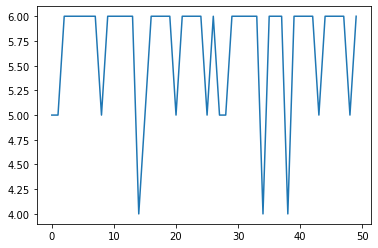

In [69]:
import matplotlib.pyplot as plt

plt.plot(hist.max(axis=1))
plt.show()